# Purpose: Experimentation with using TF Explain to do streak localization. This was before I began using differenced images to find transients. At the time, I searched through all regions of an image so streaks would not be centered in the middle and so I needed a way to figure out where the streak was located.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool
import cupy as cp
from cupyx.scipy.ndimage.filters import convolve
import tensorflow as tf
import innvestigate
import reproject
import astroscrappy
import subprocess
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from tf_explain.core import GradCAM, SmoothGrad, IntegratedGradients, OcclusionSensitivity
from tensorflow.keras.models import load_model
import tables

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Using TensorFlow backend.


In [2]:
model = load_model("/home/fwang/wandb/run-20200419_062135-rljo4afi/model-best_0.0004998333888703765_0.9704852426213106_0.9609805.h5")
thresh = 0.9704852426213106

In [3]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 2)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0   

In [6]:
fileh = tables.open_file('/media/rd1/ztf_neos/training_examples/batches/fixed_norm.h5', mode='r')

print("Loading Val Dataset")

val_images = fileh.root.val_images
val_labels = fileh.root.val_labels

val_images = val_images[:]
val_labels = val_labels[:]

print("Processing Val Dataset")
val_images[~np.isfinite(val_images)] = 0

Loading Val Dataset
Processing Val Dataset


In [5]:
explainer = OcclusionSensitivity()

In [6]:
out = explainer.explain(([image], None), model, 0)

NameError: name 'image' is not defined

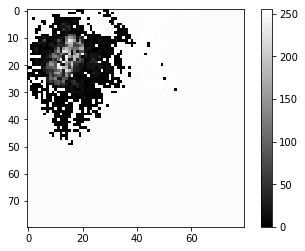

In [75]:
plt.imshow(out, cmap="gray")
plt.colorbar()

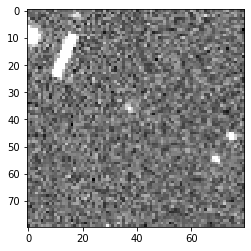

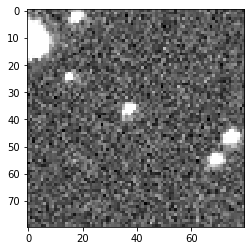

In [66]:
plt.imshow(image[..., 0], cmap="gray")
plt.figure()
plt.imshow(image[..., 1], cmap="gray")

In [14]:
model.get_layer("input_1").output

<tf.Tensor 'input_1:0' shape=(None, 80, 80, 2) dtype=float32>

In [81]:
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    inputs = tf.cast([image], tf.float32)
    conv_outputs, predictions = grad_model(inputs)
    loss = predictions[:, 0]

In [83]:
grads = tape.gradient(loss, conv_outputs)

In [84]:
print(grads)

tf.Tensor(
[[[[-1.06344211e-09  1.78413764e-08  1.37761633e-08 ... -7.24960536e-09
    -1.63084168e-09  5.39704947e-09]
   [-5.33355360e-09  1.02492068e-08  1.08758700e-08 ...  8.87084717e-09
     3.08977306e-08 -8.79596129e-09]
   [-5.87017013e-08  5.98029004e-08  5.40289946e-08 ... -1.63983778e-08
     8.10696292e-08  1.13079768e-08]
   ...
   [-6.99150959e-09  8.26138713e-10 -1.62801744e-10 ...  1.53188817e-09
    -1.02543385e-09 -6.50957621e-10]
   [-3.76287224e-09  1.95165062e-09  8.32769076e-10 ...  3.91689847e-10
    -5.59161051e-10 -2.85043544e-10]
   [-1.77874313e-10  2.70240857e-10 -5.43130818e-11 ... -1.07839115e-09
     9.60091784e-10  6.70443978e-10]]

  [[-1.56070339e-08  4.33391101e-08  3.82499898e-08 ...  1.23984236e-08
    -1.25382904e-08  9.78881509e-09]
   [-1.90306828e-08  1.60724039e-08  1.75281767e-09 ... -2.18301057e-08
     1.78256556e-08 -1.38151881e-08]
   [-3.33997860e-08  6.97571636e-08  3.58736472e-08 ...  1.18875974e-07
     1.27136062e-07 -2.43249509e-08]

In [7]:
image = val_images[val_labels==1][100]

In [8]:
layer_name = "conv2d_2"
print(layer_name)

conv2d_2


In [9]:
outputs, guided_grads = GradCAM.get_gradients_and_filters(model, [image], layer_name, 0)

In [34]:
cams = GradCAM.generate_ponderated_output(outputs, guided_grads)

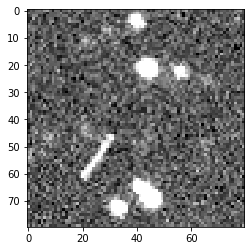

In [35]:
plt.imshow(image[..., 0], cmap="gray")

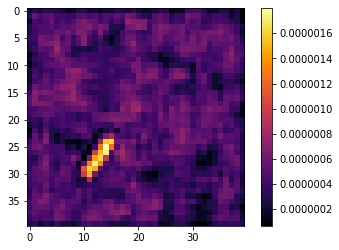

In [38]:
plt.imshow(cams[0], cmap="inferno")
plt.colorbar()

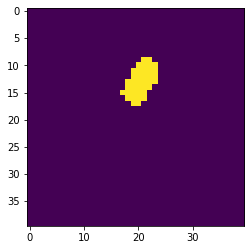

In [273]:
image = np.array(cams[0])

threshold = np.std(image) + np.mean(image)

segm = detect_sources(image, threshold, 10, connectivity=4)

plt.imshow(segm)

# segm = deblend_sources(image, segm, 20, connectivity=4)

info = source_properties(image, segm)

best_streak = None
best_score = 0

for obj in info:
    cutout = obj.data_cutout_ma
    elongation = obj.elongation
    bbox = [obj.bbox.ixmin, obj.bbox.ixmax, obj.bbox.iymin, obj.bbox.iymax]
    bbox = np.array(bbox, np.float64)
    length = (cutout.shape[0]**2 + cutout.shape[1]**2)**(1/2)
    if best_score < np.max(cutout):
        best_score = np.max(cutout)
        did_work = True
        best_streak = cutout, bbox

In [275]:
print(bbox)

[17. 24.  9. 18.]
